# Feature Creation for Credit Card Data

* Motivation:

The digitalization of our world has expanded the reach of vendors by allowing them to commercialize their items through the web. However, this has facilitated payment frauds and every year there number of fraudulent transactions keeps on rising. Banks have thus strated to rely on algorithms to be able to detect fraud wihtin seconds. By creating business rules and combining these with predictive modeling many banks have been able to reduce their fraudulent transaction count. But, before any modeling or business rules are created there is a process of feature engineering that has to take place in order to understand customers. The purpose of this assigment is to create new features based on transaction history that make sense and have the capability of enhancing our models or facilitates the creation of business rules.

* Resources:
        
        *Data on credit card transactions from employees of different agencies.
        *Word 2 Vec Trained Model
        *Rattle Data R package
        *klaR package
        
* Methods:
        
        *Bin creation Based on Quantiles
        *Creating Flag for Amount Spent in Months and Weeks per User
        *K-Means Clustering for Merchants using a Word 2 Vec Trained Model
        
* Objective:

Create several new variables that extract features from the original 12 variables that could potentially be used to create new business rules or enhance a predictive model.

In [1]:
#loading the libraries needed
library(Information)
library(data.table)
library("rattle.data")
library("tidyverse")
library(cluster)
library("klaR")
library(lubridate)
library(tokenizers)
library(ggthemes)
library(cluster)
options(repr.plot.width=18, repr.plot.height=8)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, mo

In [2]:
#Loading the data and adjusting the formats
setwd("/Users/luislosada/Columbia Drive/Anomaly Detection/Module 3")
data<-fread("purchase_credit_card.csv")

data$`Transaction Date` <-as.POSIXct(data$`Transaction Date`,tryFormats= c("%m/%d/%Y %H:%M:%S"))
data$`Posted Date` <-as.POSIXct(data$`Posted Date`,tryFormats= c("%m/%d/%Y %H:%M:%S"))


I'll start by decomposing the date variable to gain some insights from it. Usage of credit cards usually peaks on weekends or around the time where a paycheck is expected. I'll extract these features from the transaction date and create a dummy variable to identify these instances.

In [3]:
#Is it a weekend
data$is_weekend<-ifelse(wday(data$`Transaction Date`,label = TRUE) == "Sat" | 
                          wday(data$`Transaction Date`,label = TRUE) == "Sun"|
                          wday(data$`Transaction Date`, label = TRUE) == "Fri",yes=1,no=0)

#Is it around paycheck (15,30)
data$paycheck<-ifelse(format(data$`Transaction Date`, "%d") == "15" |
                   format(data$`Transaction Date`, "%d") == "30",
                 yes = 1, no= 0)

#Week Number
data$week_num <- week(data$`Transaction Date`)

#Month Number
data$month_num <- month(data$`Transaction Date`)

Next I'll look at the spread between a transaction date and its posted date. A big spread is an alert that something did not go right with that transaction.Therefore, we are creating a dummy variable that flags a spread of more than 3 days between transaction and posted date.

In [4]:
#Is posted Date greater than 3 days produce a flag
table(as_date(data$`Posted Date`)-as_date(data$`Transaction Date`))
data$long_post_date<-ifelse(as_date(data$`Posted Date`)-as_date(data$`Transaction Date`) > 3, 
                            yes=1,no=0)



     0      1      2      3      4      5      6      7      8      9     10 
 18616 201903 106620  76380  31073   2937   1306   1587    707    254    225 
    11     12     13     14     15     16     17     18     19     20     21 
   179     71     61     63     36     45     36     34     24     31     20 
    22     23     24     25     26     27     28     29     30     31     32 
    26     11     11      5      8     21     16     18      8      3     12 
    33     34     35     36     37     38     39     40     41     42     44 
    10      6      5      4      6      5      2      9      2      5      3 
    45     46     47     48     50     52     53     54     56     57     58 
     3      4      3      4      1      2      1      2      3      1      1 
    59     62     63     66     68     69     70     71     73     78     88 
     3      4      2      1      2      1      2      1      1      1      1 
    95    100    101    104    106    130    160    183 
     2

Identifying the users for this dataset is complicated. Lets create a user id for each unique user. Users will be considered unique if the key has a unique value on these variables: Agency, First Initial and Last Name.

In [5]:
#Creating a Unique ID for all the Clients
for_id<-unique(data[,c("Agency Name","Cardholder Last Name","Cardholder First Initial")])
uid = vector(mode = "character", length = NROW(for_id))
for (i in 1:NROW(for_id)){
 uid[i]<-paste("uid_",as.character(i),sep="") 
}
for_id$User_ID<-uid

data<-cbind(User_ID = rep(0,NROW(data)),data)
add_variable<- function(data,comp){
  for (i in 1:NROW(comp)){
      ind = which(data[,"Agency Name"] == comp$`Agency Name`[i] & 
                  data[,"Cardholder Last Name"] == comp$`Cardholder Last Name`[i] &
                  data[,"Cardholder First Initial"] == comp$`Cardholder First Initial`[i])
      data$User_ID[ind] = comp$User_ID[i]
    }
return(data)
  }

df=add_variable(data,for_id)

In [6]:
str(df)

Classes ‘data.table’ and 'data.frame':	442458 obs. of  17 variables:
 $ User_ID                     : chr  "uid_1" "uid_1" "uid_2" "uid_3" ...
 $ Year-Month                  : int  201307 201307 201307 201307 201307 201307 201307 201307 201307 201307 ...
 $ Agency Number               : int  1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 ...
 $ Agency Name                 : chr  "OKLAHOMA STATE UNIVERSITY" "OKLAHOMA STATE UNIVERSITY" "OKLAHOMA STATE UNIVERSITY" "OKLAHOMA STATE UNIVERSITY" ...
 $ Cardholder Last Name        : chr  "Mason" "Mason" "Massey" "Massey" ...
 $ Cardholder First Initial    : chr  "C" "C" "J" "T" ...
 $ Description                 : chr  "GENERAL PURCHASE" "ROOM CHARGES" "GENERAL PURCHASE" "GENERAL PURCHASE" ...
 $ Amount                      : num  890 369 165.8 96.4 126 ...
 $ Vendor                      : chr  "NACAS" "SHERATON HOTEL" "SEARS.COM 9300" "WAL-MART #0137" ...
 $ Transaction Date            : POSIXct, format: "2013-07-30 12:00:00" "2013-07-30 1

The variables week and month number, created above, provide almost no real insights. However, if we group by user and either week or month then we could find the amounts considered as outliers in a weekly and monthly basis. Using the boxplot function we can extract these features with ease and add them to our set.

In [7]:
#Extract week number, groupby user and week and sum amount by week,see what is an outlier and flag it
week_outlier<-df%>%
  group_by(User_ID,week_num)%>%
  summarize(Amount_Per_Week = sum(Amount))

OutVals = boxplot(Amount_Per_Week~User_ID,
                  data = as.data.frame(week_outlier),
                  plot=F)

ww<-week_outlier[which(week_outlier$Amount_Per_Week %in% OutVals$out),]



In [8]:
df$flag_week_amount<-rep(0,NROW(df))
for (i in 1:NROW(ww)){
  out_ind<-which(df$User_ID == ww$User_ID[i] & df$week_num == ww$week_num[i])
  df$flag_week_amount[as.numeric(out_ind)]<-1
}

In [29]:
#Extract Month number, groupby user and month and sum amount by month,see what is an outlier and flag it

month_outlier<-df%>%
  group_by(User_ID,month_num)%>%
  summarize(Amount_Per_Month = sum(Amount))

OutMonth = boxplot(Amount_Per_Month~User_ID,
                  data = as.data.frame(month_outlier),
                  plot=F)
mm<-month_outlier[which(month_outlier$Amount_Per_Month %in% OutMonth$out),]

df$flag_month_amount<-rep(0,NROW(df))
for (i in 1:NROW(mm)){
  out_ind<-which(df$User_ID == mm$User_ID[i] & df$month_num == mm$month_num[i])
  df$flag_month_amount[as.numeric(out_ind)]<-1
}

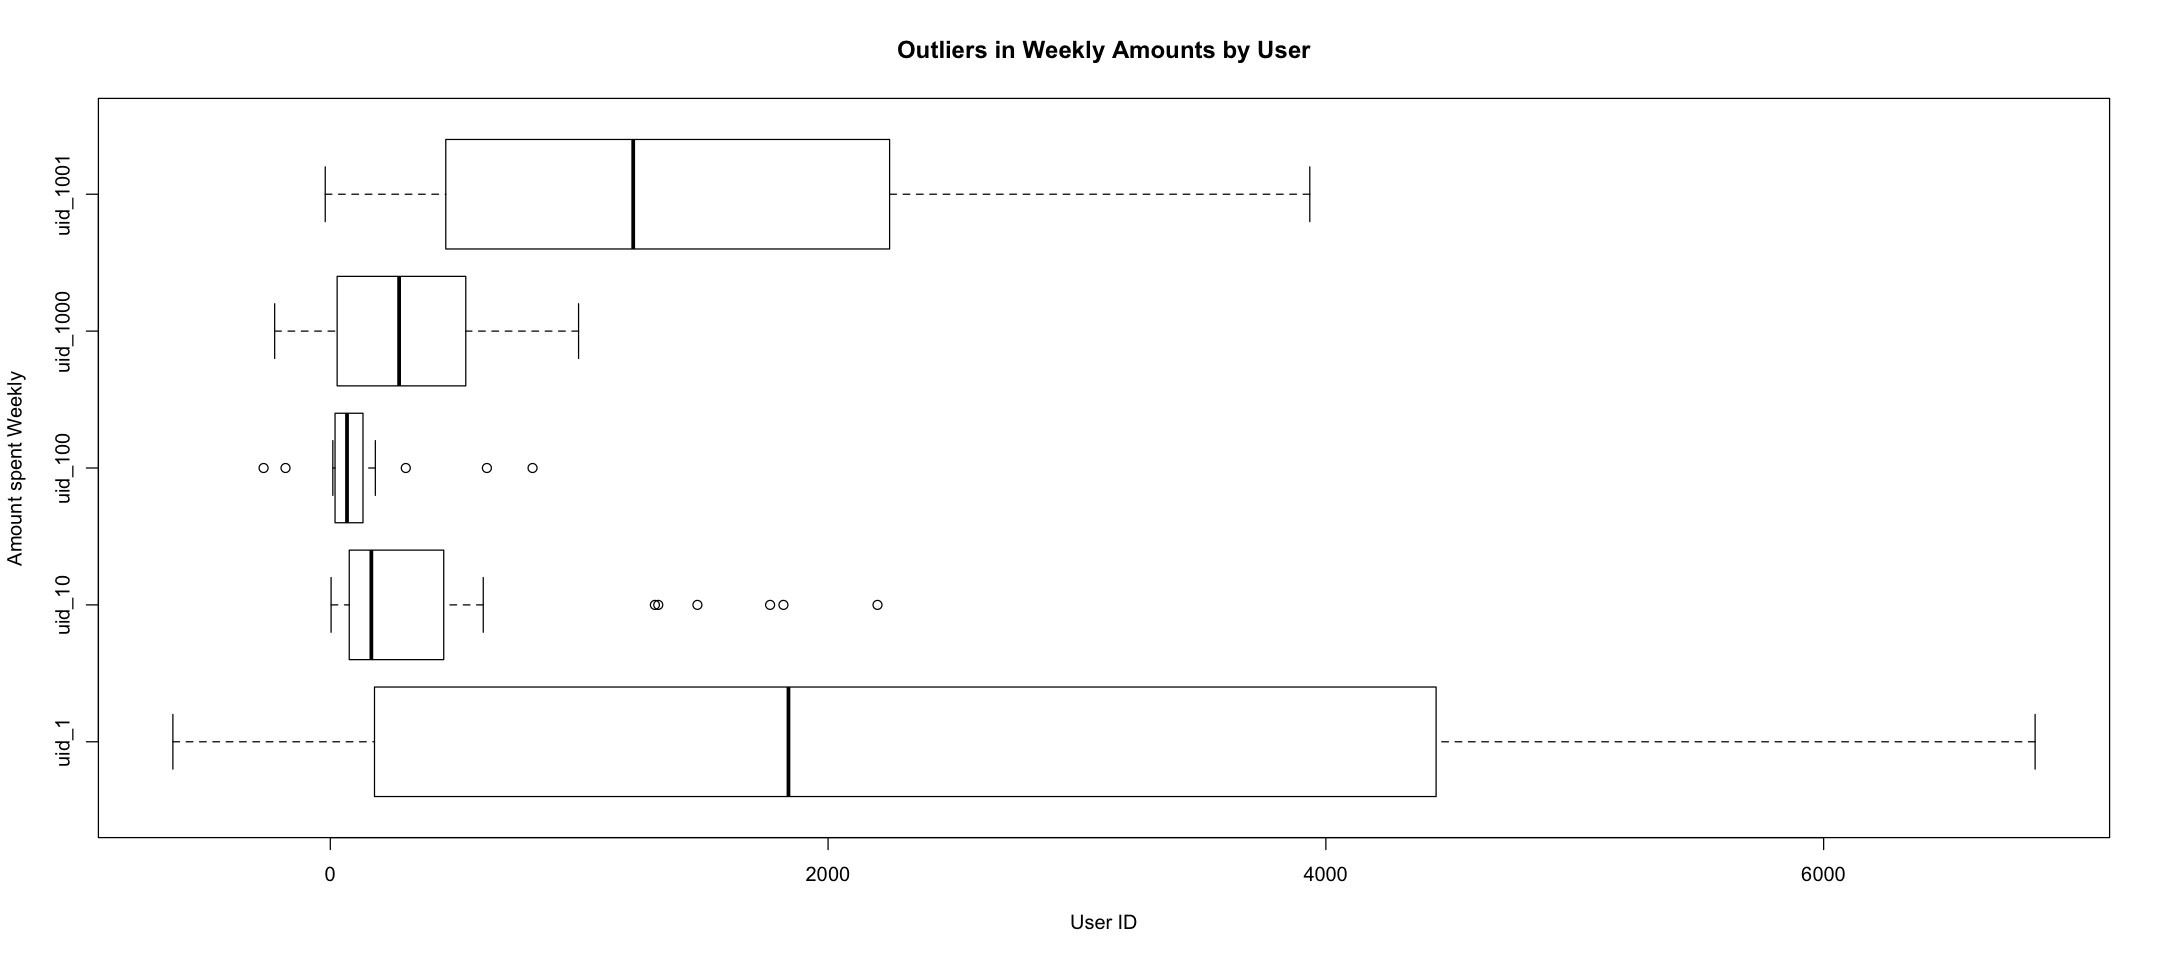

In [10]:
#Take a look at the first 100 observations
OutVals = boxplot(Amount_Per_Week~User_ID,
                  data = as.data.frame(week_outlier)[c(1:100),],
                  main = "Outliers in Weekly Amounts by User",
                  xlab = "User ID",
                  ylab = "Amount spent Weekly",
                  horizontal = T,
                  notch = F,
                  plot=T)

Lets look at another useful feature engineering technique; binning. In this case I'll use the "amount" variable in order to grasp more insight into client behavior.

In [11]:
set.seed(123)
spec = c(train = .5, test = .25, validate = .25)

g = sample(cut(
  seq(nrow(df)), 
  nrow(df)*cumsum(c(0,spec)),
  labels = names(spec)
))

df_list = split(df, g)

# Check the results:
sapply(df_list, nrow)/nrow(df)

train    = df_list$train
test     = df_list$test
validate = df_list$validate

train.amount.cut = quantile(train$Amount, prob = seq(0, 1, 0.1))
train.amount.cut

Bin_Set <- df %>% 
  mutate(amount.equalSize = cut(Amount, breaks = train.amount.cut)
  )
head(Bin_Set)

equalSize.matrix = model.matrix(~amount.equalSize,Bin_Set)
final_df<-cbind(df,as.data.frame(equalSize.matrix))
head(final_df)


train      test  validate 
0.5000000 0.2499989 0.2500011

0%         10%         20%         30%         40%         50% 
 -42863.040      12.610      25.000      41.444      69.990     105.000 
        60%         70%         80%         90%        100% 
    167.918     270.000     441.000     820.000 1750379.980

User_ID,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC),is_weekend,paycheck,week_num,month_num,long_post_date,flag_week_amount,flag_month_amount,amount.equalSize
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
uid_1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30 12:00:00,2013-07-31 12:00:00,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,0,1,31,7,0,0,0,"(820,1.75e+06]"
uid_1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30 12:00:00,2013-07-31 12:00:00,SHERATON,0,1,31,7,0,0,0,"(270,441]"
uid_2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29 12:00:00,2013-07-31 12:00:00,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE CLASSIFIED,0,0,30,7,0,0,0,"(105,168]"
uid_3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30 12:00:00,2013-07-31 12:00:00,"GROCERY STORES,AND SUPERMARKETS",0,1,31,7,0,1,0,"(70,105]"
uid_4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30 12:00:00,2013-07-31 12:00:00,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRITING PAPER",0,1,31,7,0,0,0,"(105,168]"
uid_4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,GENERAL PURCHASE,394.28,KYOCERA DOCUMENT SOLUTION,2013-07-29 12:00:00,2013-07-31 12:00:00,"OFFICE, PHOTOGRAPHIC, PHOTOCOPY, AND MICROFILM EQUIPMENT",0,0,30,7,0,0,0,"(270,441]"


Warning message in data.table::data.table(...):
“Item 2 is of size 442456 but maximum size is 442458 (recycled leaving remainder of 2 items)”


User_ID,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,⋯,(Intercept),"amount.equalSize(12.6,25]","amount.equalSize(25,41.4]","amount.equalSize(41.4,70]","amount.equalSize(70,105]","amount.equalSize(105,168]","amount.equalSize(168,270]","amount.equalSize(270,441]","amount.equalSize(441,820]","amount.equalSize(820,1.75e+06]"
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dttm>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
uid_1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30 12:00:00,⋯,1,0,0,0,0,0,0,0,0,1
uid_1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30 12:00:00,⋯,1,0,0,0,0,0,0,1,0,0
uid_2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29 12:00:00,⋯,1,0,0,0,0,1,0,0,0,0
uid_3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30 12:00:00,⋯,1,0,0,0,1,0,0,0,0,0
uid_4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30 12:00:00,⋯,1,0,0,0,0,1,0,0,0,0
uid_4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,GENERAL PURCHASE,394.28,KYOCERA DOCUMENT SOLUTION,2013-07-29 12:00:00,⋯,1,0,0,0,0,0,0,1,0,0


With our bins ready now lets flag suspicous behavior. If the amount that the client spends is in a bin where less than 5% of all the transactions made by that ID comes up then we flag that transaction as suspicous.

In [12]:
#Flagging Based on Amount
final_df$flag_amount_bin<-rep(0,NROW(final_df))
flag<-function(set,ids){
  ff = vector(mode = "numeric",length = NROW(set))
  c=0
  for (i in 1:length(ids)){
    dd<-set[User_ID==ids[i]]
    ss<-as.data.frame(dd[,c("amount.equalSize(12.6,25]","amount.equalSize(25,41.4]",
                            "amount.equalSize(41.4,70]","amount.equalSize(70,105]",
                            "amount.equalSize(105,168]","amount.equalSize(168,270]",
                            "amount.equalSize(270,441]","amount.equalSize(441,820]",
                            "amount.equalSize(820,1.75e+06]")])  
    prop_tab<-as.data.frame(apply(ss,2,sum)/NROW(dd))
    ind<-which(prop_tab<0.05 & prop_tab!=0) #less than 5% of transactions
    rr<-row.names(prop_tab)[ind]
    if (length(rr)>0){
      c=c+1
      for (j in 1:length(rr)){
        for (k in 1:NROW(ss)){
          print(ss[k,rr[j]])
          if(ss[k,rr[j]]==1){
            ff[c]<-1
            }
        }
     
      }

    }else{
      ff[c]<-0
      c=c+1
    }
    }
  return(ff)
  }

final_df$flag_amount_bin<-flag(final_df,unique(final_df$User_ID))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



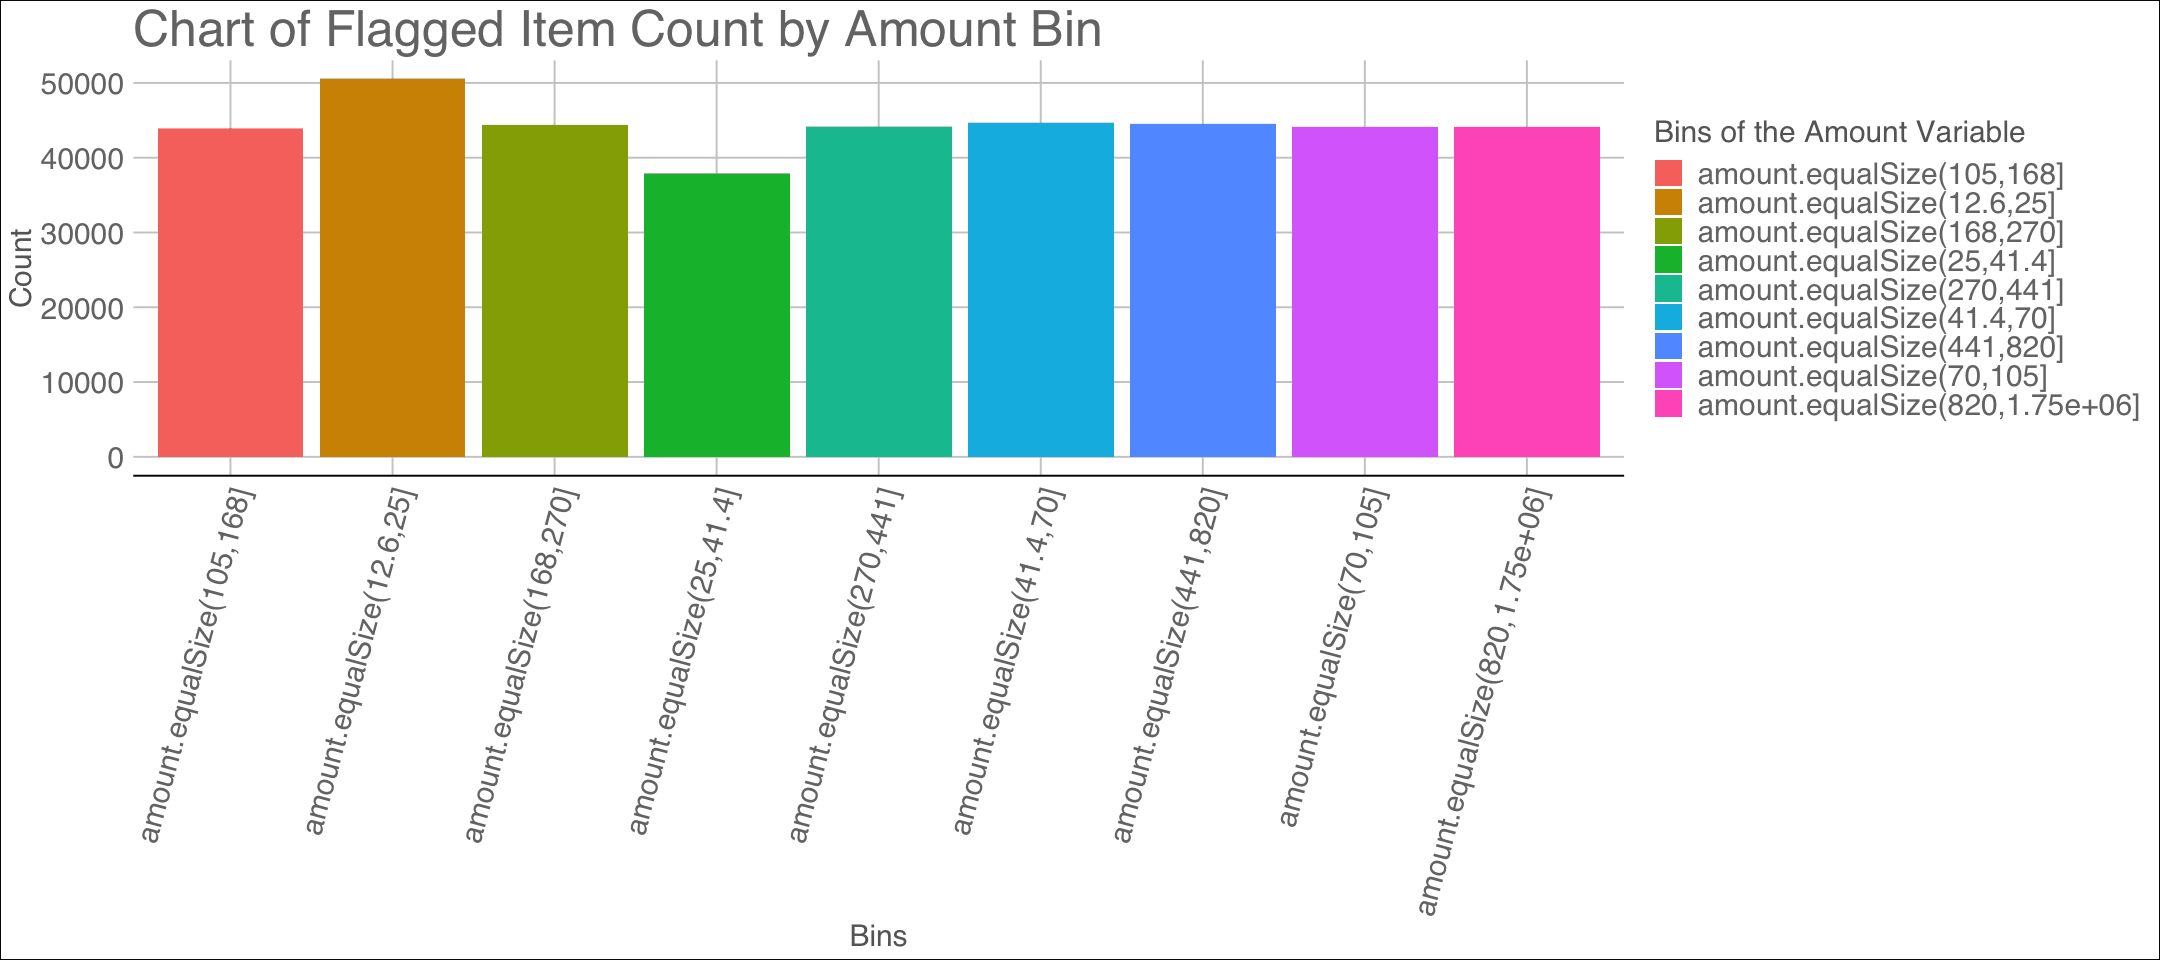

In [18]:
#Looking at the Bins Created
Long_DF<-final_df %>% gather(Bin, Cnt, 21:29)
For_Bar<-as.data.frame(Long_DF)[which(Long_DF$Cnt == 1),]

For_Bar[,c(22,23)]%>%
    ggplot(aes(x=Bin,y=Cnt,fill=Bin))+
    geom_bar(stat="identity")+
    theme_gdocs()+
    theme(axis.text.x = element_text(angle = 75, hjust = 1))+
    labs(fill = "Bins of the Amount Variable")+
    xlab("Bins")+
    ylab("Count")+
    theme(text = element_text(size=18))+
    ggtitle("Chart of Flagged Item Count by Amount Bin")
    

#### Adding Some NLP to our Feature Engineering

For the next step I'll use a NLP model to analyze the merchant category variable. First lets take a look at it.

In [19]:
summary(as.factor(final_df$`Merchant Category Code (MCC)`))

STATIONERY, OFFICE SUPPLIES, PRINTING AND WRITING PAPER 
                                                        24860 
                                                  BOOK STORES 
                                                        21981 
                 INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED 
                                                        21669 
      DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP AND SUP. 
                                                        20183 
                              GROCERY STORES,AND SUPERMARKETS 
                                                        17152 
                    MISCELLANEOUS AND SPECIALTY RETAIL STORES 
                                                        13335 
                                 HOME SUPPLY WAREHOUSE STORES 
                                                        13254 
                                            AMERICAN AIRLINES 
                                                        12015 
                                              TRAVEL AGENCIES 
                                                        11777 
                                   TELECOMMUNICATION SERVICES 
                                                        10358 
                   BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED 
                                                        10147 
                   STATIONERY,OFFICE AND SCHOOL SUPPLY STORES 
                                                         9947 
                                              HARDWARE STORES 
                                                         9031 
                GOVERNMENT SERVICES--NOT ELSEWHERE CLASSIFIED 
                                                         8919 
       COURIER SERVICES-AIR AND GROUND,AND FREIGHT FORWARDERS 
                                                         8234 
     OFFICE, PHOTOGRAPHIC, PHOTOCOPY, AND MICROFILM EQUIPMENT 
                                                         7728 
                      AUTOMOTIVE PARTS AND ACCESSORIES STORES 
                                                         7141 
    DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE CLASSIFIED 
                                                         6994 
               COMMERCIAL EQUIPMENT, NOT ELSEWHERE CLASSIFIED 
                                                         6969 
                               ELECTRICAL PARTS AND EQUIPMENT 
                                                         6549 
                  PLUMBING AND HEATING EQUIPMENT AND SUPPLIES 
                                                         6476 
                                    AIRLINES AND AIR CARRIERS 
                                                         6180 
                                            CATALOG MERCHANTS 
                                                         5854 
           COMPUTERS, COMPUTER PERIPHERAL EQUIPMENT, SOFTWARE 
                                                         5504 
                                           ELECTRONICS STORES 
                                                         5504 
       CHEMICALS AND ALLIED PRODUCTS NOT ELSEWHERE CLASSIFIED 
                                                         4851 
                      UTILITIES - ELECTRIC,GAS,WATER,SANITARY 
                                                         4764 
                                EATING PLACES AND RESTAURANTS 
                                                         4335 
                                        FAST FOOD RESTAURANTS 
                                                         4316 
                                           SOUTHWEST AIRLINES 
                                                         3982 
                  CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS 
                                                         3866 
                   NON-DURABLE GOODS NOT ELSEWHERE CLASSIFIED 
                                     

The data seems messy and there is not a great deal of insights that we can grab from it. To help us clean it up then lets use some NLP. Using the Word2Vec algorithm in Python and a pretrained Google News model I was able to create a 2 dimensional vector of all the words in this variable. The code for the creation of the word vectors can be found [here]('https://drive.google.com/open?id=1sdcSRY3CONQcJuU7dCgRel3_LM69zOl5').

In [20]:
#importing vector of words created in python
vec_word=read.csv("/Users/luislosada/Columbia Drive/Anomaly Detection/Module 3/vector_of_words.csv", header=T)
data_x = vec_word[,2:3]

Using that vector I will then use a k-means clusters algorithm to create clusters of words. These clusters can help me narrow down the categories from the merchant variable to 5 labels. 

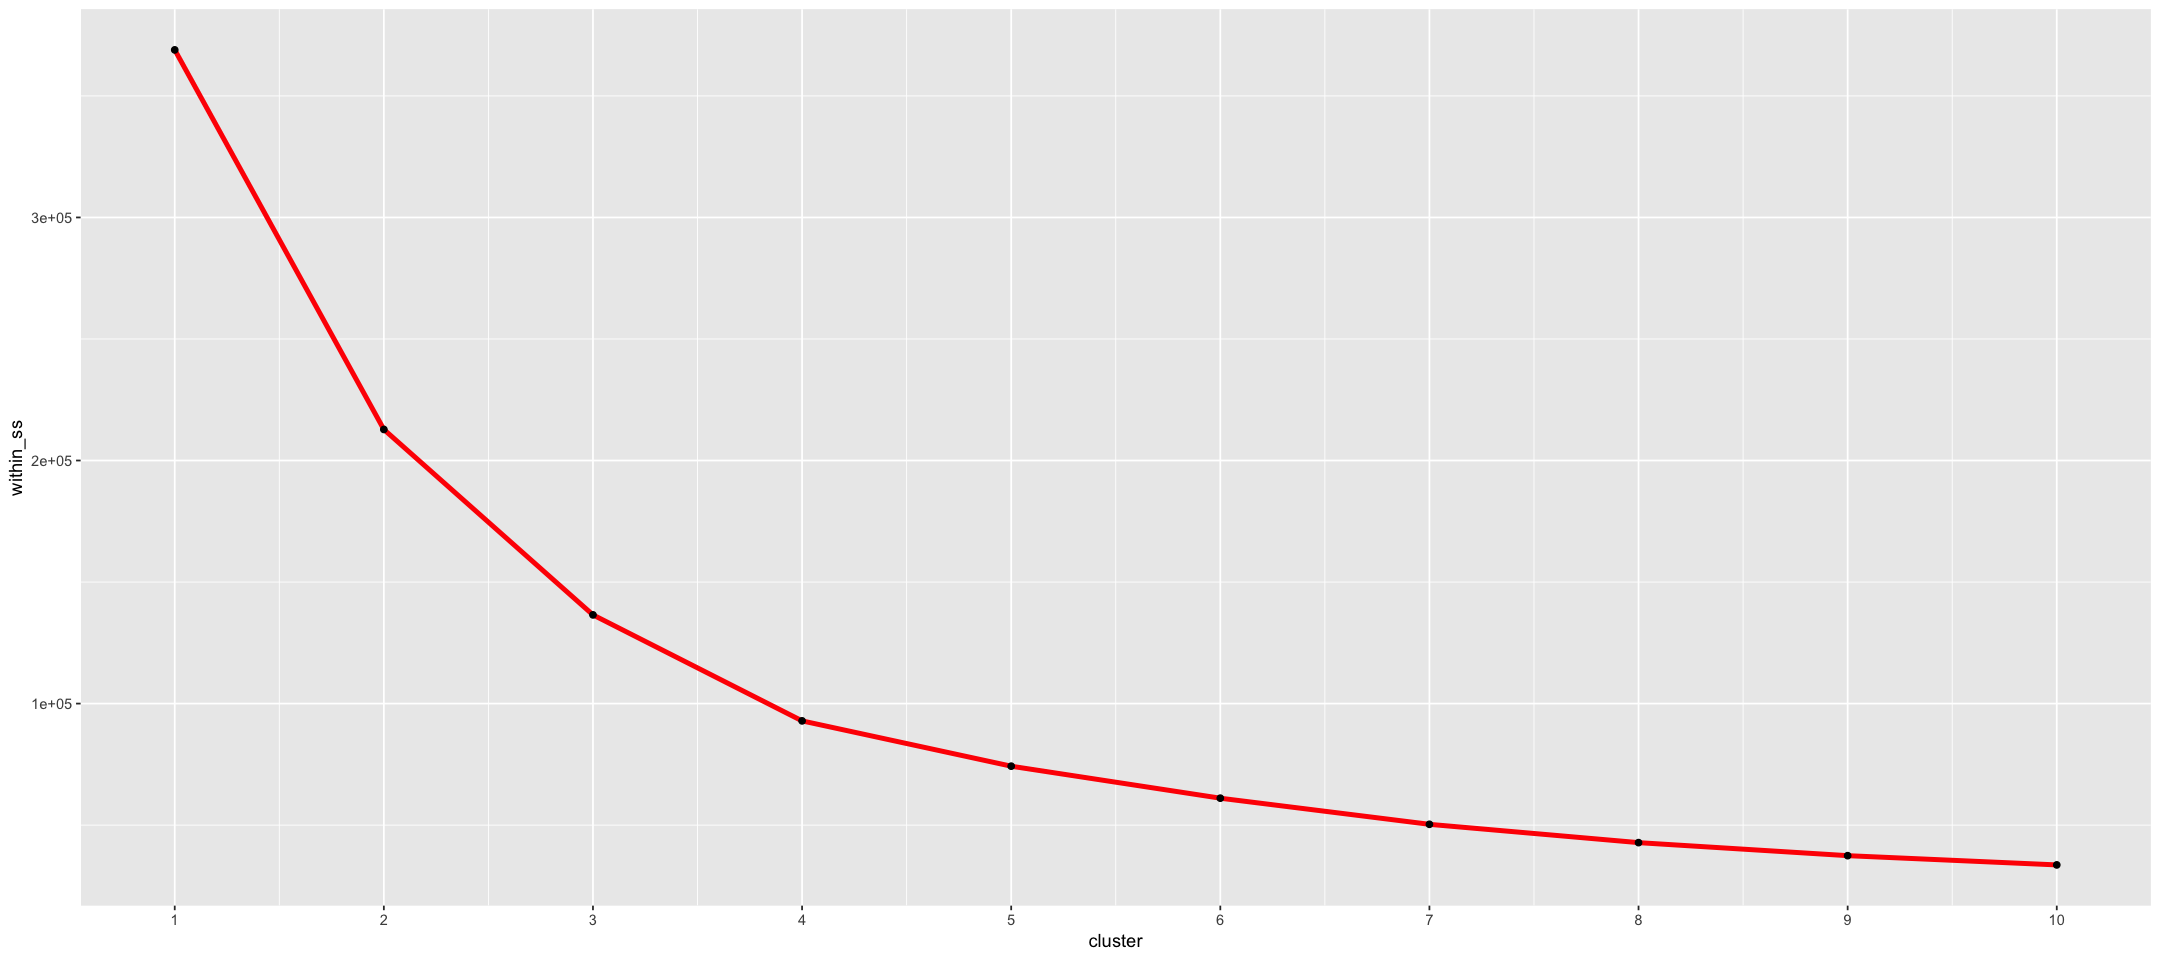

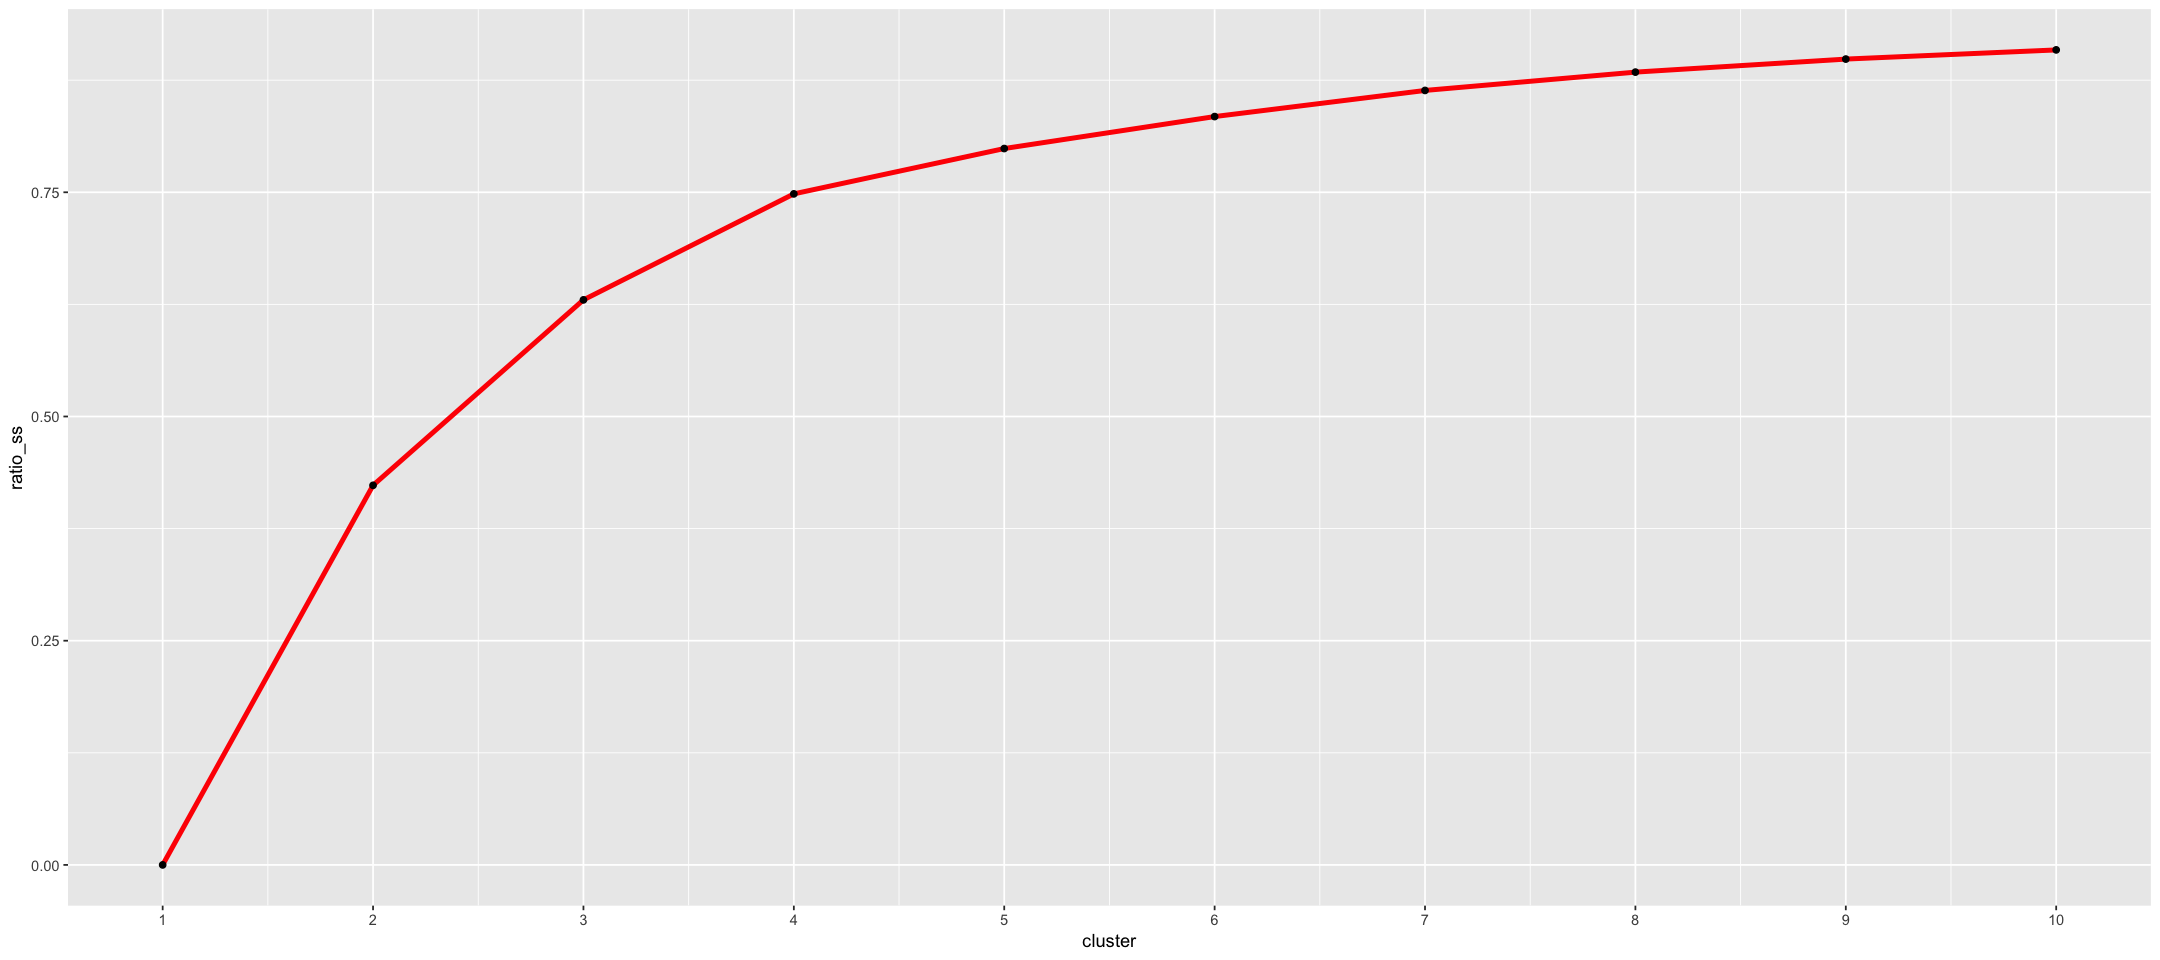


  1   2   3   4   5 
180 175 272 226 277 

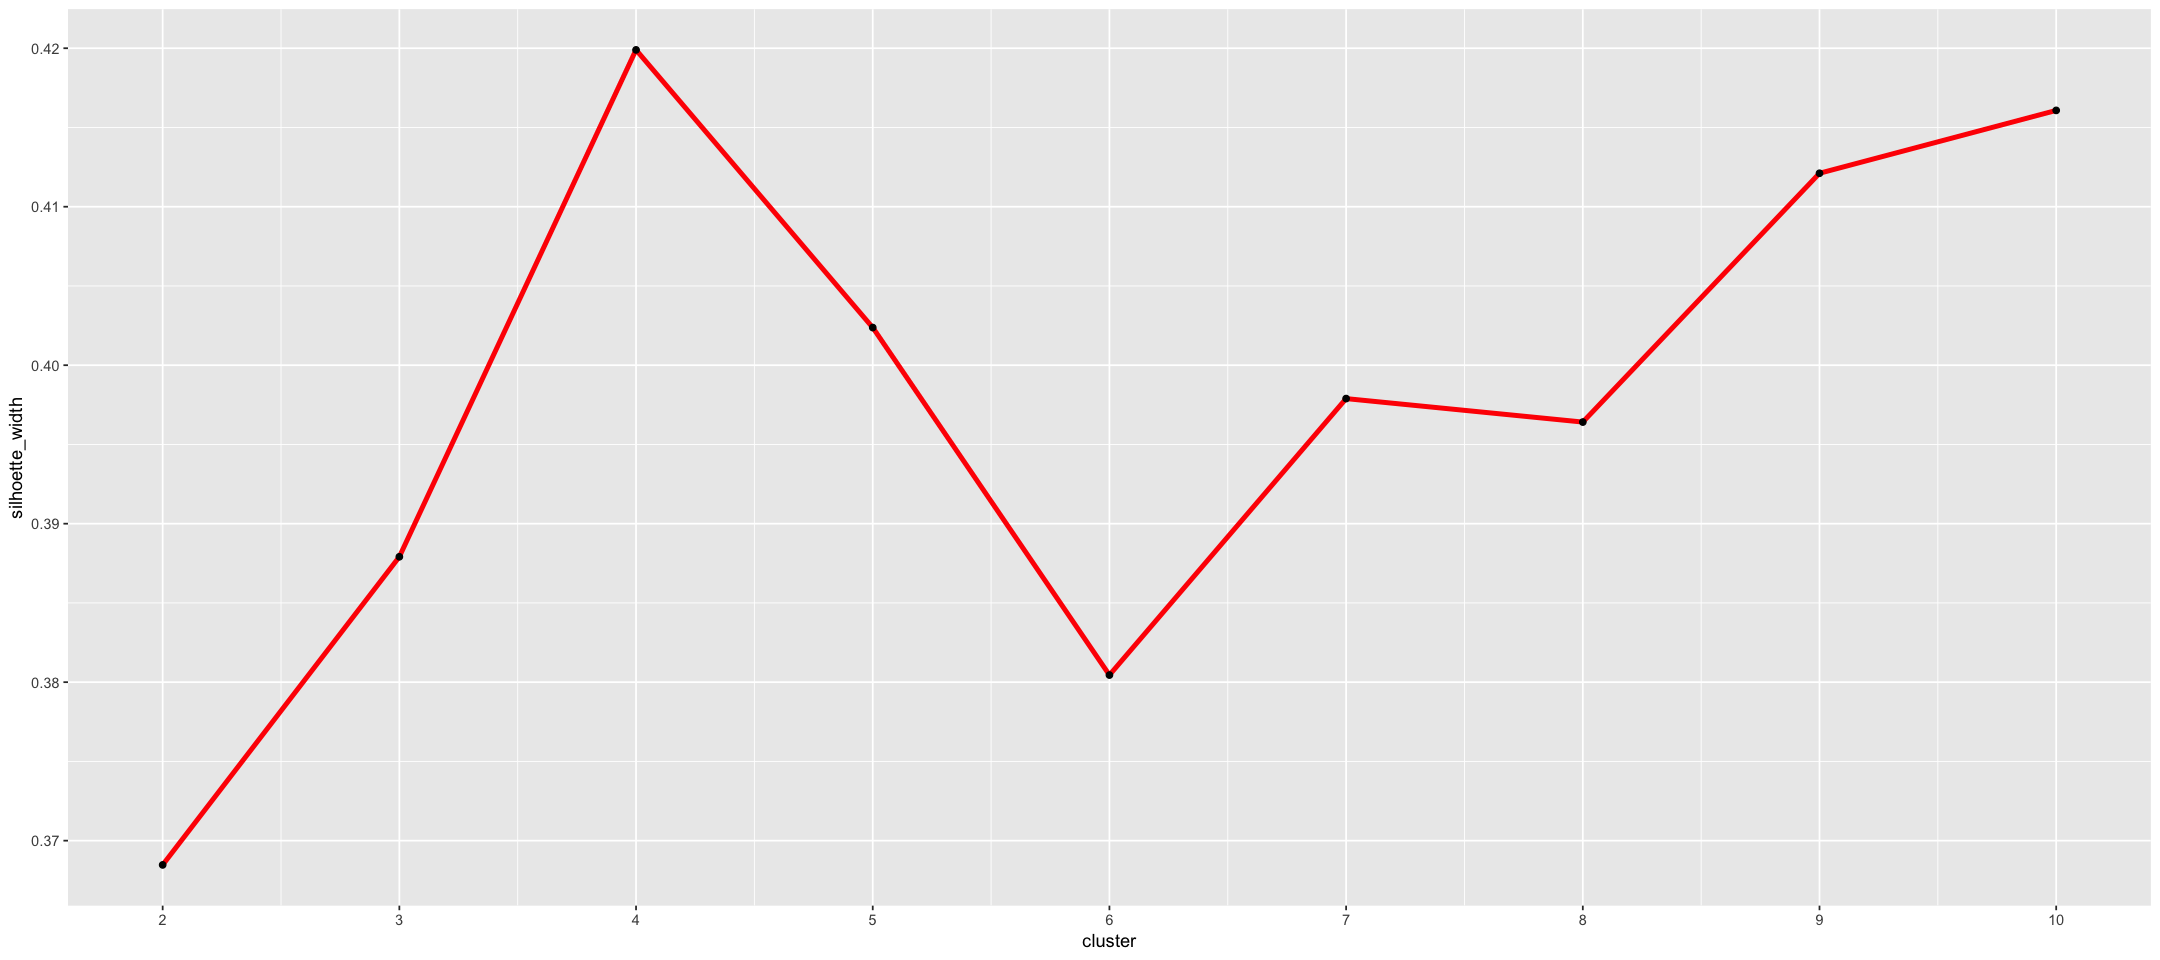

In [21]:
#run total within sum of squares for 1-10 clusters
within_ss=sapply(1:10, FUN=function(x) kmeans(x=data_x, centers=x, iter.max=1000, nstart=20)$tot.withinss)
ggplot(data=data.frame(cluster=1:10, within_ss), aes(x=cluster, y=within_ss))+
  geom_line(col='red', size=1.4)+
  geom_point()+
  scale_x_continuous(breaks=seq(1,10,1))

#ratio plot
ratio_ss = sapply(1:10,FUN = function(x) {km = kmeans(x = data_x,centers = x,iter.max = 1000,nstart = 20)
km$betweenss/km$totss} )
ggplot(data=data.frame(cluster = 1:10,ratio_ss),aes(x=cluster,y=ratio_ss))+
  geom_line(col='red',size=1.4)+
  geom_point()+
  scale_x_continuous(breaks=seq(1,10,1))

#silhouette plot

silhoette_width = sapply(2:10,FUN = function(x) pam(x = data_x,k = x)$silinfo$avg.width)
ggplot(data=data.frame(cluster = 2:10,silhoette_width),aes(x=cluster,y=silhoette_width))+
  geom_line(col='red',size=1.4)+
  geom_point()+
  scale_x_continuous(breaks=seq(2,10,1))

set.seed(20)
data_cluster<-kmeans(data_x, 5, nstart=10)
table(data_cluster$cluster)


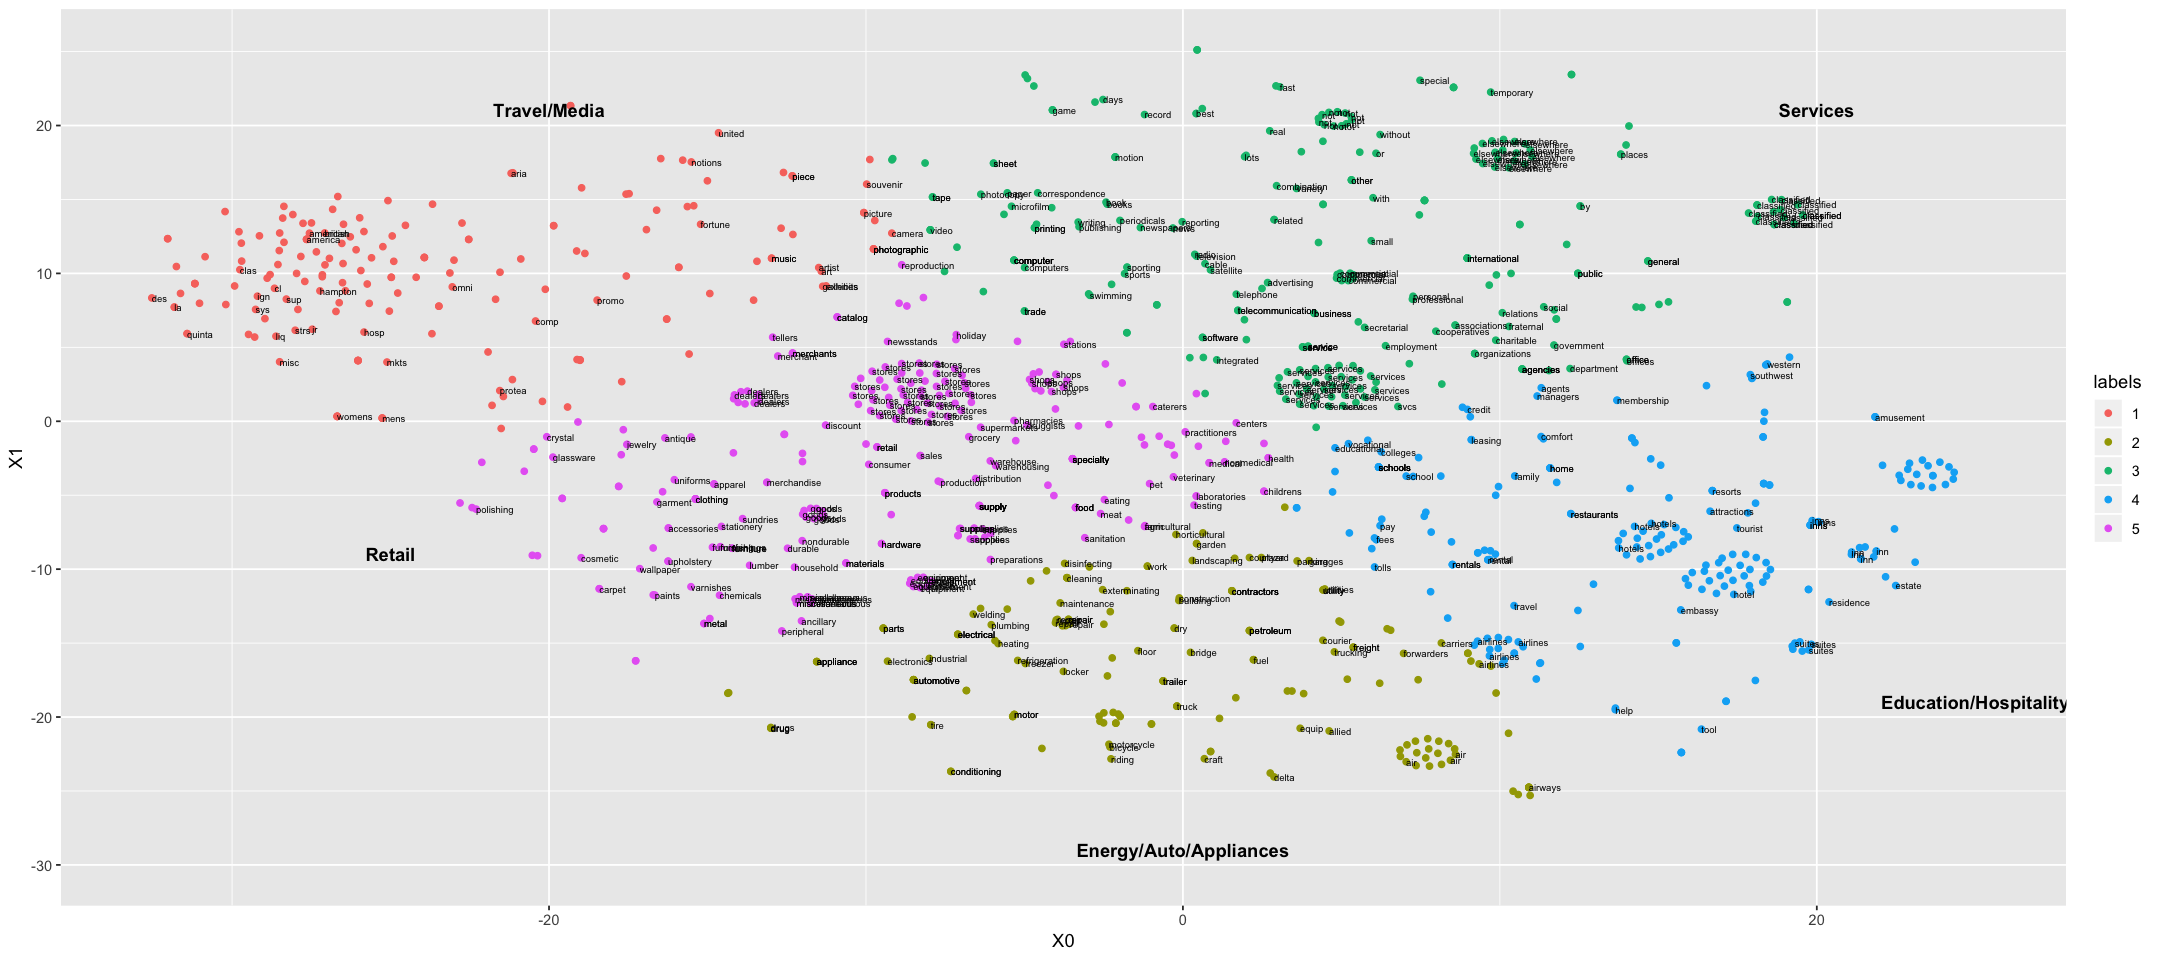

In [22]:
#Visualize n clusters
label_100<- as.character(vec_word[1:500,]$labels)
label_100[(501):nrow(vec_word)] <- rep("", (nrow(vec_word)-500))

orig_plot<-ggplot(vec_word, aes(X0, X1, color=as.factor(data_cluster$cluster)))+
  geom_point()+guides(color=guide_legend("labels"))

orig_plot+annotate("text", x = vec_word$X0, y=vec_word$X1, hjust = 0,
                   label=label_100, color="black",size = 2)+
  annotate("text", x=-20, y=20,label='atop(bold("Travel/Media"))',parse =T)+
  annotate("text", x=20, y=20, label='atop(bold("Services"))',parse =T)+
  annotate("text", x=0, y=-30, label='atop(bold("Energy/Auto/Appliances"))',parse =T)+
  annotate("text", x=25, y=-20, label='atop(bold("Education/Hospitality"))',parse =T)+
  annotate("text", x=-25, y=-10,label='atop(bold("Retail"))',parse =T)

data_2<-cbind(vec_word, cluster = data_cluster$cluster)

data_2$classification = ifelse(data_2$cluster == 1, yes = "Travel/Media",
                               no = ifelse(data_2$cluster == 2, yes = "Energy/Auto/Appliances",
                                           no = ifelse(data_2$cluster == 3, yes = "Services",
                                                       no = ifelse(data_2$cluster == 4, yes = "Education/Hospitality",
                                                                   no = "Retail"))))


We've come up with 5 clusters that explain a little better the category of each transaction. Now lets apply these categories to the dataset. To do this I'll match each word in the merchant category to a word in our cluster and calculate what percentage of the words in the string correpond to what cluster. The highest porcentage then wins and the observation is labeled with the winning cluster.

In [23]:
#Labeling Each Merchant into the 5 Bins
merc_list<-unique(final_df$`Merchant Category Code (MCC)`)
tokens_list<-tokenize_words(merc_list)

df_cluster <- function(words,data){
  w<-as.character(words)
  d<-as.character(data$labels)
  df<-data.frame()
  cluster_of_word =vector()
  for (i in 1:NROW(d)){
    for (j in 1:length(w)){
      if(length(w[j]) >0 & length(d[i])>0){
        if(!is.na(w[j]) & !is.na(d[i])){
        if (w[j] == d[i]){
          cluster_of_word[j]<-data$cluster[i]
      }}}
    }
    df<-cluster_of_word
  }
  return(df)
}

categories<- function (merch,cdata){
  merc_cat<-vector()
  for (i in 1:length(merch)) {
    pre<-df_cluster(merch[[i]],cdata)
    #print(pre)
    prop<-prop.table(table(pre))
    pp<-as.numeric(names(prop[which.max(prop)]))
    ifelse(test = length(prop)>0,yes = pre_cat<-pp,no = pre_cat<-c(0))
    if (pre_cat == 1){
      cat<-c("Travel/Media")
    }else if (pre_cat == 2){
      cat<-c("Energy/Auto/Appliances")
    }else if (pre_cat == 3){
      cat<-c("Services")
    }else if (pre_cat == 4){
      cat<-c("Education/Hospitality")
    }else if (pre_cat == 5){
      cat<-c("Retail")
    }else {
      cat<-NA
    }
    merc_cat[i]<-cat
  }
  return(merc_cat)
}


  

In [24]:
cat<-categories(tokens_list,data_2)
merc_list_ready<-as.data.frame(cbind(cat,merc_list))

final_df$merc_class<-rep(0,NROW(final_df))
for (j in 1:NROW(merc_list)){
    ix<-which(final_df$`Merchant Category Code (MCC)`==merc_list_ready$merc_list[j])
    if (length(ix)>0){
      final_df$merc_class[ix]<-as.character(merc_list_ready$cat[j])
    }
  }


Finally with all the features ready lets take a look at the final result.

In [27]:
tail(final_df[,c(12,31)],10)

Merchant Category Code (MCC),merc_class
<chr>,<chr>
AUTOMOTIVE PARTS AND ACCESSORIES STORES,Energy/Auto/Appliances
"COMMERCIAL EQUIPMENT, NOT ELSEWHERE CLASSIFIED",Services
"MISC. AUTOMOTIVE,AIRCRAFT,AND FARM EQUIPMENT DEALERS",Retail
AUTOMOTIVE PARTS AND ACCESSORIES STORES,Energy/Auto/Appliances
"COMMERCIAL EQUIPMENT, NOT ELSEWHERE CLASSIFIED",Services
HARDWARE EQUIPMENT AND SUPPLIES,Retail
"UTILITIES - ELECTRIC,GAS,WATER,SANITARY",Energy/Auto/Appliances
BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,Services
PROFESSIONAL SERVICES NOT ELSEWHERE CLASSIFIED,Services


### Conclusions

The final result is a dataset with 32 Variables that aim to explain and catch unusual behavior amongst transactions made by users. The dataset per se does not offer a lot of insights into the behahvior of clients and makes it hard to catch any irregularities. Adding flags for suspicious behavior based on time frames and amount allows us to profile better unusual activities. Moreover, binning the amounts variable lets us udnerstand better wether a transaction is an outlier or not. Outliers are the first step to determining suspicious behavior, so flagging abnormal occurances in the amount variable provides enough insight for us to learn more about the data.
Finally, the merchants and vendors categories seem like useless variables because the data is not clean enough. However, some NLP work can help us understand the relationship between these categories and help us narrow down the labels to a reasonable number.

In [28]:
write_csv(final_df,"complete_df.csv")